# Turing.jl

Turing.jl is a probabilistic programming in Julia. If you are familiar with Stan or PyMC, you will quickly feel at home with Turing.jl.

Like all probabilistic programming languages, Turing.jl's goal is to make Bayesian inference easy by decoupling statistical models and inference algorithms: You can write your model using an intuitive syntax that looks like maths, and use many different inference methods on it without understanding the details of the methods.

Turing's design principles resembles those of Julia's: You can do almost anything, and if you write your code with care it can be blazing fast. This is its greatest departure from Stan: Stan imposes strict constraints on what can be included in a model and how one can perform inference. Turing is far more flexible, for better and for worse.

Turing's greatest strength is its integration with the wider Julia scientific computing ecosystem: Distributions.jl, DifferentialEquations.jl, and several automatic differentiation packages interoperate well with Turing. You'll see some examples of this in the course of the afternoon.

This tutorial will introduce you to Turing in a hands-on manner. We will
1. Cover some examples of basic usage of Turing.jl
2. Let you try out writing your own models
3. Go through some slightly more advanced usage
4. Talk about state space models, and how they work with Turing

## Basics: How to write a model

For a toy problem, let's assume we have a loaded 6-sided die, and we want to figure out the probability distribution of it landing on each of its 6 sides.

In [ ]:
import Pkg
Pkg.activate(".")
Pkg.add("Distributions")
Pkg.add("Turing")
Pkg.add("StatsPlots")
Pkg.add("Plots")
Pkg.add("DataFrames")

First, let's create the die and generate some data from it, to which we can fit our model.

mean(dice) = 4.5
mode(dice) = 6


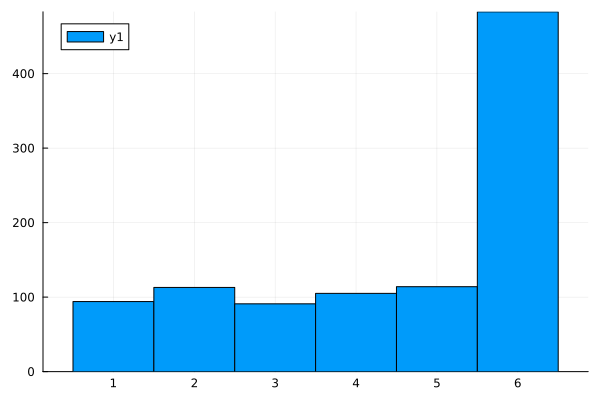

In [20]:
using Distributions
using StatsPlots
using Plots
using Random

Random.seed!(23)

dice = Categorical([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])

@show mean(dice)
@show mode(dice)

data = rand(dice, 1_000)
histogram(data, bins=0.5:1:6.5)

Here's how we can model a 6-sided die in Turing.

In [ ]:
using Turing

@model function dice_throw(num_throws)
    # Random variable p is a 6-dimensional vector
    # with the probabilities for the 6 different outcomes.
    # It's prior distribution is set to be Dirichlet(6, 1),
    # which is uniform.
    #
    # The ~ statement is the only new addition to normal Julia
    # syntax introduced by the @model macro from Turing. It reads
    # as "p is distributed according to Dirichlet(6, 1)".
    # It also sets the variable p to value, which by default
    # is sampled from the distribution.
    p ~ Dirichlet(6, 1)

    # throws is the random variable for the outcomes of throws.
    # It's distribution is Categorical(p) for each throw.
    throws ~ product_distribution([Categorical(p) for _ in 1:num_throws])
end

# With the model defined, we can instantiate a model with our data
my_model = dice_throw(length(data)) | (; throws=data)
# The | denotes conditioning. The above is equivalent with
# my_model = condition(dice_throw(length(data)); throws=data)


SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


DynamicPPL.Model{typeof(dice_throw), (:num_throws,), (), (), Tuple{Int64}, Tuple{}, DynamicPPL.ConditionContext{@NamedTuple{throws::Vector{Int64}}, DynamicPPL.DefaultContext}}(Main.dice_throw, (num_throws = 1000,), NamedTuple(), ConditionContext((throws = [5, 6, 6, 2, 5, 6, 3, 6, 1, 2, 5, 1, 6, 6, 4, 6, 2, 6, 6, 6, 6, 4, 6, 6, 6, 6, 3, 3, 6, 6, 4, 6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 3, 2, 2, 4, 3, 1, 2, 6, 6, 6, 6, 4, 1, 6, 5, 1, 6, 6, 6, 5, 4, 6, 5, 6, 2, 6, 6, 6, 2, 6, 1, 6, 6, 6, 6, 6, 3, 6, 4, 6, 1, 6, 6, 6, 3, 5, 6, 5, 6, 1, 4, 4, 1, 2, 4, 6, 2, 5, 6, 1, 5, 5, 6, 6, 5, 3, 6, 5, 3, 2, 6, 6, 6, 4, 2, 6, 6, 5, 3, 6, 6, 6, 2, 5, 6, 6, 3, 6, 6, 2, 1, 1, 1, 6, 6, 1, 6, 6, 5, 2, 5, 1, 5, 6, 6, 6, 6, 6, 6, 5, 2, 1, 5, 3, 3, 6, 2, 5, 6, 5, 4, 2, 6, 2, 6, 1, 5, 4, 6, 5, 6, 2, 6, 6, 6, 6, 6, 3, 1, 6, 6, 1, 6, 2, 5, 3, 6, 6, 6, 5, 6, 6, 2, 2, 6, 5, 6, 2, 5, 6, 6, 6, 5, 4, 6, 3, 5, 4, 4, 6, 1, 4, 4, 6, 6, 6, 1, 3, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 3, 1, 6, 6, 6, 3, 3, 5, 6, 6, 3, 6, 5, 6, 6, 6, 3, 3, 6,

## Basics: Inference

Let's sample from the posterior of `my_model` using a Markov Chain Monte Carlo sampler called NUTS.

In [ ]:
chain_nuts = sample(my_model, NUTS(), 1_000)

Sampling   0%|                                          |  ETA: N/A
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
Sampling   1%|▎                                         |  ETA: 0:00:08
Sampling   1%|▍                                         |  ETA: 0:00:09
Sampling   2%|▋                                         |  ETA: 0:00:07
Sampling   2%|▉                                         |  ETA: 0:00:06
Sampling   3%|█▏                                        |  ETA: 0:00:06
Sampling   3%|█▎                                        |  ETA: 0:00:05
Sampling   4%|█▌                                        |  ETA: 0:00:05
Sampling   4%|█▋                                        |  ETA: 0:00:05
Sampling   5%|█▉                                        |  ETA: 0:00:05
Sampling   5%|██▏                                       |  ETA: 0:00:04
Sampling   6%|██▍                                       |  ETA: 0:00:05
Sampling   6

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.88 seconds
Compute duration  = 2.88 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics

  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

        p[1]    0.0947    0.0094    0.0002   2133.7563   748.7792    0.9993    ⋯
        p[2]    0.1131    0.0096    0.0002   1784.2946   793.4008    1.0056    ⋯
        p[3]    0.0911    0.0089    0.0002   2618.3351   820.4943    1.0017    ⋯
        p[4]    0.1055    0.0096    0.0002   1941.4464   825.3109    0.9991    ⋯
        p[5]  


Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:00
Sampling  98%|█████████████████████████████████████████▏|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▍|  ETA: 0:00:00
Sampling  99%|█████████████████████████████████████████▋|  ETA: 0:00:00
Sampling 100%|█████████████████████████████████████████▊|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████| Time: 0:00:02
Sampling 100%|██████████████████████████████████████████| Time: 0:00:02


`chain_nuts` contains 1000 samples from the posterior, which we can investigate in various ways:

In [ ]:
describe(chain_nuts)

Chains MCMC chain (1000×20×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 2.88 seconds
Compute duration  = 2.88 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Summary Statistics

  parameters      mean       std      mcse    ess_bulk   ess_tail      rhat    ⋯
      Symbol   Float64   Float64   Float64     Float64    Float64   Float64    ⋯

        p[1]    0.0947    0.0094    0.0002   2133.7563   748.7792    0.9993    ⋯
        p[2]    0.1131    0.0096    0.0002   1784.2946   793.4008    1.0056    ⋯
        p[3]    0.0911    0.0089    0.0002   2618.3351   820.4943    1.0017    ⋯
        p[4]    0.1055    0.0096    0.0002   1941.4464   825.3109    0.9991    ⋯
        p[5]  

In [40]:
quantile(chain_nuts)

Quantiles

  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

        p[1]    0.0777    0.0881    0.0945    0.1007    0.1135
        p[2]    0.0958    0.1063    0.1130    0.1197    0.1331
        p[3]    0.0740    0.0849    0.0909    0.0971    0.1086
        p[4]    0.0867    0.0992    0.1053    0.1115    0.1240
        p[5]    0.0963    0.1069    0.1140    0.1212    0.1334
        p[6]    0.4517    0.4711    0.4812    0.4917    0.5106



You can make all sorts of plots from the data yourself, but simply calling `plot(chain_nuts)` gives you trace plots to see that sampling has converged, and density plots of the marginals of each variable, for a quick overview.

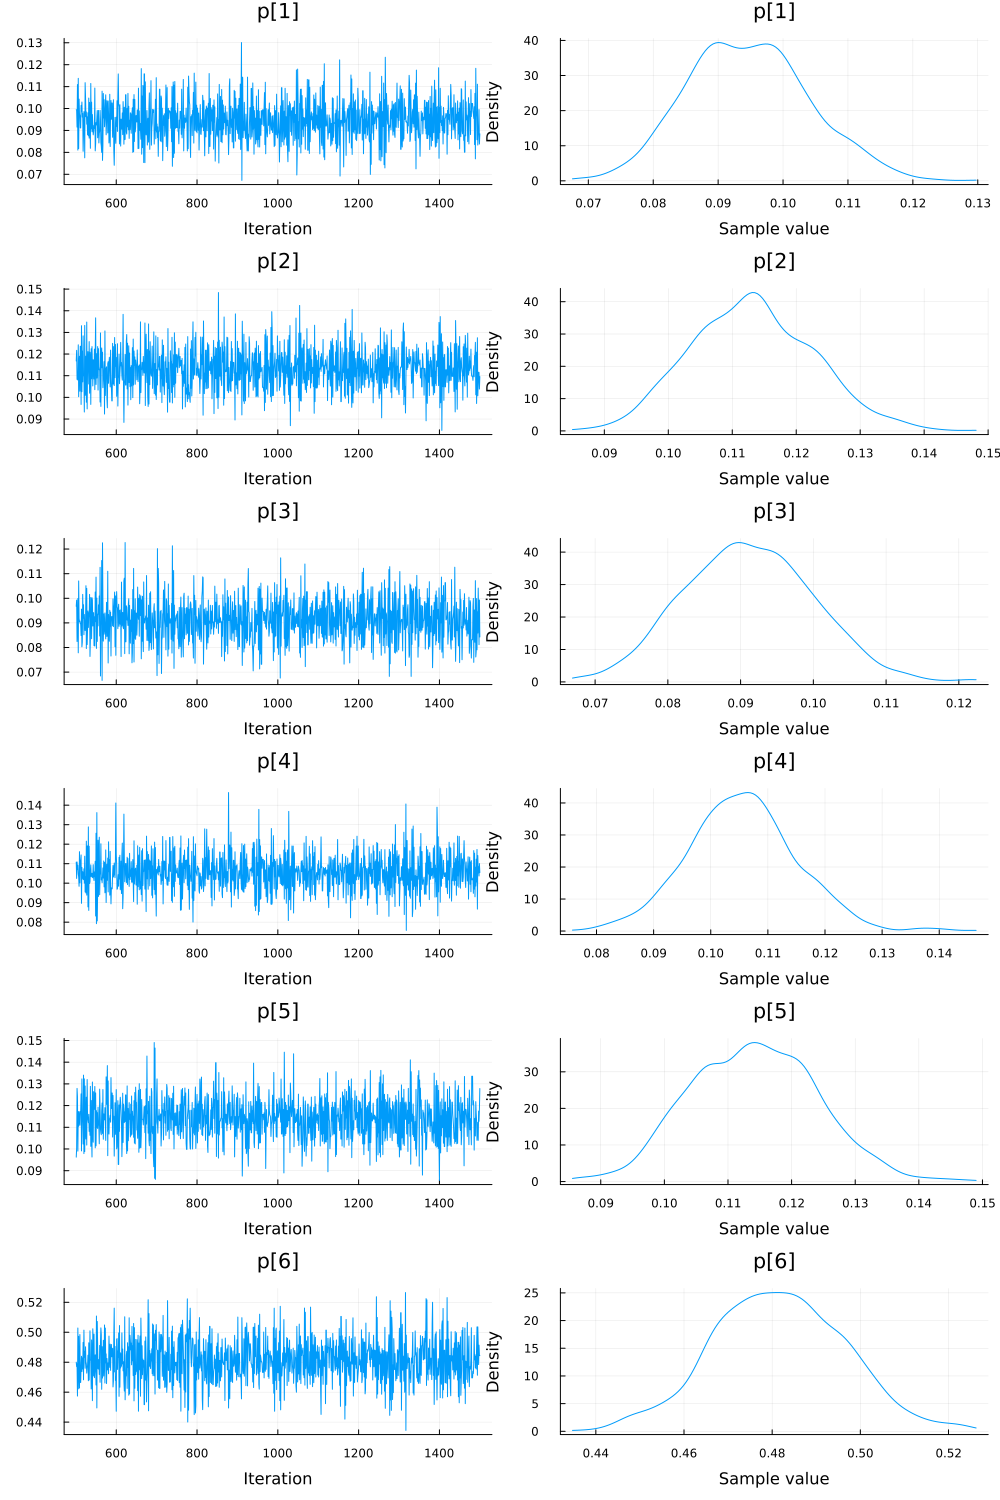

In [27]:
plot(chain_nuts)

You can also convert the whole chain into a `DataFrame`, and do all the usual statistical analysis you would on a `DataFrame`. Note that the columns include not just the values of all our random variables `p[i]`, but also various diagnostics from the sampler. We can ignore them for now.

In [34]:
using DataFrames
DataFrame(chain_nuts)

1000×22 DataFrame
  Row │ iteration  chain  p[1]       p[2]      p[3]       p[4]       p[5]      ⋯
      │ Int64      Int64  Float64    Float64   Float64    Float64    Float64   ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │       501      1  0.0994377  0.116797  0.0967275  0.110799   0.0962445 ⋯
    2 │       502      1  0.0992999  0.121701  0.0992444  0.102442   0.100306
    3 │       503      1  0.0915256  0.108296  0.0824302  0.110865   0.127896
    4 │       504      1  0.110926   0.111727  0.0889541  0.106959   0.124041
    5 │       505      1  0.0810416  0.107982  0.0998867  0.109257   0.0990199 ⋯
    6 │       506      1  0.113773   0.124259  0.0778323  0.104686   0.117245
    7 │       507      1  0.0817302  0.100305  0.107032   0.103189   0.110468
    8 │       508      1  0.10429    0.114481  0.0918167  0.0983959  0.117149
  ⋮   │     ⋮        ⋮        ⋮         ⋮          ⋮          ⋮          ⋮     ⋱
  994 │      1494      1  0.111081   0.12752   0.0945175  0.0866944  0.108896  ⋯
  995 │      1495      1  0.0833395  0.10071   0.0858749  0.114178   0.112291
  996 │      1496      1  0.0875464  0.106378  0.104135   0.105192   0.103986
  997 │      1497      1  0.090059   0.111624  0.0939425  0.108486   0.117456
  998 │      1498      1  0.0995141  0.11152   0.0811537  0.103686   0.112746  ⋯
  999 │      1499      1  0.0837994  0.103854  0.0993166  0.110039   0.118526
 1000 │      1500      1  0.0884628  0.109589  0.0842814  0.105435   0.127844
                                                 15 columns and 985 rows omitted

You can easily run multiple chains in parallel, like so:

In [ ]:
chains_nuts = sample(my_model, NUTS(), MCMCThreads(), 1_000, 4; progress=false)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220


Chains MCMC chain (1000×20×4 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 4
Samples per chain = 1000
Wall duration     = 13.72 seconds
Compute duration  = 13.69 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size, lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


We used NUTS as our MCMC sampler above. It's a good default, and the main sampler in Stan. However, Turing also offers many other samplers, such as Metropolis-Hastings, particle Gibbs, elliptical slice sampling, and any combinations thereof within a Gibbs sampler. We'll touch on this a bit later, but just to demonstrate, switching samplers is as easy as

In [73]:
# Using Metropolis-Hastings
chain_mh = sample(my_model, MH(), 1_000; progress=false)

Chains MCMC chain (1000×9×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.86 seconds
Compute duration  = 0.86 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


Just because you can sample with a sampler, doesn't mean that the results are any good. Do check the outcome. For instance, in this case, the Metropolis-Hastings sampler makes very slow progress, as can be seen from the effective sample size (ESS) and the trace plots:

In [62]:
describe(chain_mh)

Chains MCMC chain (1000×9×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.58 seconds
Compute duration  = 0.58 seconds
parameters        = p[1], p[2], p[3], p[4], p[5], p[6]
internals         = lp, logprior, loglikelihood

Summary Statistics

  parameters      mean       std      mcse   ess_bulk   ess_tail      rhat   e ⋯
      Symbol   Float64   Float64   Float64    Float64    Float64   Float64     ⋯

        p[1]    0.0939    0.0204    0.0049     7.7395    15.2222    2.5822     ⋯
        p[2]    0.1598    0.0413    0.0134     7.5491    10.1781    2.5569     ⋯
        p[3]    0.0889    0.0230    0.0045    16.1531    11.3886    2.5849     ⋯
        p[4]    0.1348    0.0280    0.0056     3.5122    17.1925    2.5494     ⋯
        p[5]    0.0851    0.0290    0.0095     7.3131     2.9179    2.5440     ⋯
        p[6]    0.4375    0.0315    0.0077    11.2983     2.7859    2.5386     ⋯

                                   

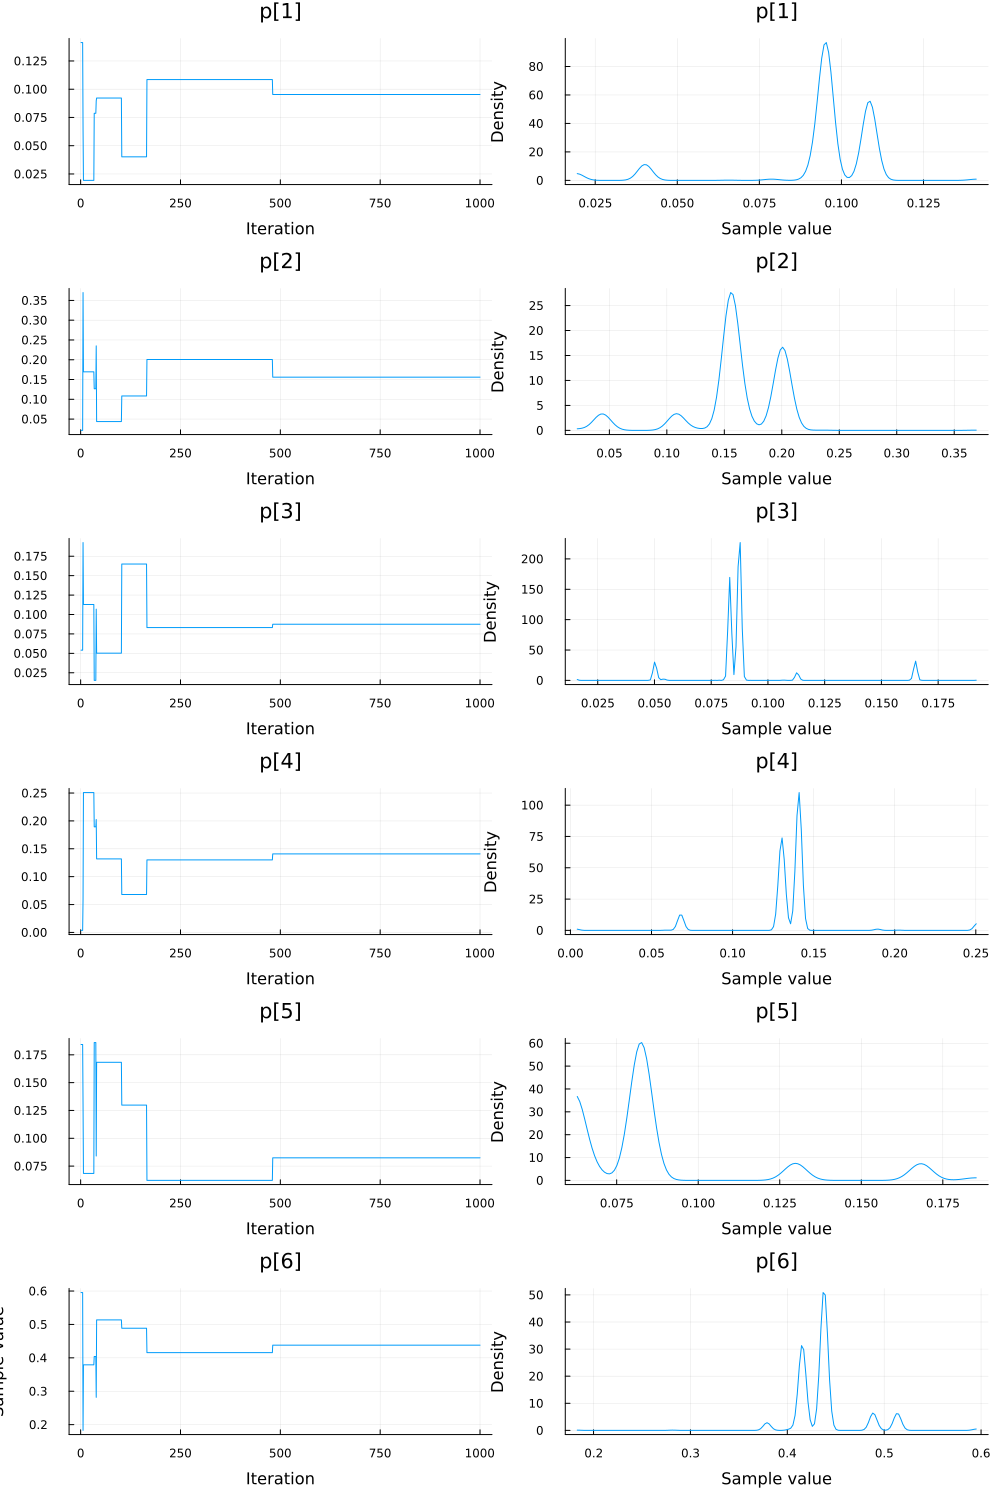

In [63]:
plot(chain_mh)


This could be fixed by tuning the sampler, but that's for later.

In our example model, we wrote everything in terms of multidimensional variables, with multidimensional distributions as priors. 

In [ ]:
@model function dice_throw(num_throws)
    p ~ Dirichlet(6, 1)
    throws ~ product_distribution([Categorical(p) for _ in 1:num_throws])
end

That's usually a good idea. However, for convenience, Turing also supports indexing into variables, so that the same model could also be written as.

In [69]:
@model function dice_throw_with_indexing(num_throws)
    p ~ Dirichlet(6, 1)
    throws = Vector{Float64}(undef, num_throws)
    for i in eachindex(throws)
        throws[i] ~ Categorical(p)
    end
end

dice_throw_with_indexing (generic function with 2 methods)

## Exercise: Linear regression

Task: Write a one-variable linear regression model in Turing, give it some made up data, and recover the original parameters used to make the data.

There are many ways to do this, but you probably want a model with two or three parameters, for the slope and intercept of the fit and possibly also for the scale of noise in your data.

Here are the true parameters we want to recover, and some dummy data:

In [85]:
true_slope = 5.4
true_intercept = -0.3
true_noise_variance = 2.3
num_points = 2_000
predictors = rand(num_points)
data = true_slope .* predictors .+ true_intercept .+ randn(num_points) .* sqrt(true_noise_variance)

2000-element Vector{Float64}:
  1.9097989865864413
  0.9940437712641557
  2.495084295930707
  2.884180808692979
  1.3587195799691774
  3.744732974376959
  3.0087366344637774
  0.6711638955456345
  3.3686120201641625
 -1.5606831874911364
  ⋮
  2.518708493344393
  4.843414143959707
  2.93893026909768
  1.0373203533612094
  3.770259689302242
  4.352701732401631
  3.7317296053078324
  1.8394873032866288
  3.2633287897408594

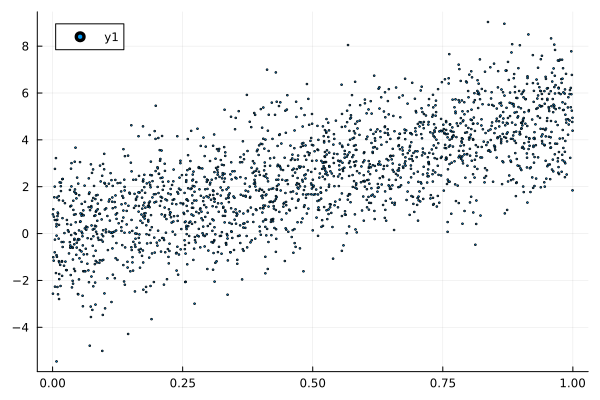

In [87]:
scatter(predictors, data, ms=1)

And here's a template for you to fill in.

In [ ]:
# Write a model to recover the slope, intercept, and noise variance from predictors and data.

@model function # TODO This function needs a name and arguments
    # TODO Fill me in please
end

# TODO Sample from the above model to find the posterior distribution for the parameters.

In [89]:
# Solution below, but first some empty space to stop accidental spoilers.
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD
# SPOILER GUARD

Here's one solution:

In [112]:
# Write a model to recover the slope, intercept, and noise variance from predictors and data.

@model function linear_regression(predictors)
    slope ~ Normal(0.0, 10.0)
    intercept ~ Normal(0.0, 10.0)
    noise_variance ~ Exponential(0.5)

    mean = slope .* predictors .+ intercept
    # The below is equivalent to
    # data ~ product_distribution([Normal(mean[i], sqrt(noise_variance) for i in 1:length(predictors)])
    # MvNormal is just a convenience function for creating multivariate normal distributions.
    data ~ MvNormal(mean, I*noise_variance)
end

lr_model = linear_regression(predictors) | (; data=data)
lr_chain = sample(lr_model, NUTS(), MCMCThreads(), 1_000, 3; progress=false)
quantile(lr_chain)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432
┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.025
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220
┌ Info: Found initial step size
│   ϵ = 0.0125
└ @ Turing.Inference /Users/mhauru/.julia/packages/Turing/EThRU/src/mcmc/hmc.jl:220


Quantiles

      parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
          Symbol   Float64   Float64   Float64   Float64   Float64 

           slope    5.1284    5.3041    5.3796    5.4583    5.6128
       intercept   -0.3457   -0.2583   -0.2125   -0.1665   -0.0703
  noise_variance    2.2440    2.3314    2.3826    2.4349    2.5443



## Basics: Studying results

Turing has various features for studying models and inference results. Let's see how they apply to the linear regression model above.

We saw a bit of this already: The chains returned by sample include various sampler statistics. These can be found under the `:internals` section:

In [94]:
mean(lr_chain; sections = :internals)

Mean

                    parameters         mean 
                        Symbol      Float64 

                       n_steps       7.3540
                     is_accept       1.0000
               acceptance_rate       0.8285
                   log_density   -3719.2060
            hamiltonian_energy    3720.6984
      hamiltonian_energy_error       0.0014
  max_hamiltonian_energy_error       0.3433
                    tree_depth       2.5783
               numerical_error       0.0000
                     step_size       0.5292
                 nom_step_size       0.5292
                            lp   -3720.0728
                      logprior     -10.6556
                 loglikelihood   -3709.4172



In [93]:
quantile(lr_chain; sections = :internals)

Quantiles

                    parameters         2.5%        25.0%        50.0%        7 ⋯
                        Symbol      Float64      Float64      Float64      Flo ⋯

                       n_steps       1.0000       7.0000       7.0000       7. ⋯
                     is_accept       1.0000       1.0000       1.0000       1. ⋯
               acceptance_rate       0.3088       0.7193       0.9143       0. ⋯
                   log_density   -3722.1592   -3719.7439   -3718.9049   -3718. ⋯
            hamiltonian_energy    3718.3893    3719.4588    3720.3692    3721. ⋯
      hamiltonian_energy_error      -0.9616      -0.1107       0.0000       0. ⋯
  max_hamiltonian_energy_error      -1.1902      -0.1726       0.1712       0. ⋯
                    tree_depth       1.0000       2.0000       3.0000       3. ⋯
               numerical_error       0.0000       0.0000       0.0000       0. ⋯
                     step_size       0.4924       0.4924       0.5007       0. ⋯
                

These are, of course, dependent on the sampler:

In [105]:
sampler = MH(Diagonal([0.1, 0.1, 0.1]))
lr_chain_mh = sample(model, sampler, MCMCThreads(), 1_000, 3; progress=false)
quantile(lr_chain_mh; sections=:internals)

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/mhauru/.julia/packages/AbstractMCMC/mcqES/src/sample.jl:432


Quantiles

     parameters          2.5%        25.0%        50.0%        75.0%        97 ⋯
         Symbol       Float64      Float64      Float64      Float64      Floa ⋯

             lp   -10891.1207   -3723.2515   -3720.5983   -3719.3020   -3718.8 ⋯
       logprior     -331.2266     -10.7709     -10.6775     -10.5781     -10.2 ⋯
  loglikelihood   -10712.9320   -3712.5202   -3709.7344   -3708.6820   -3708.2 ⋯

                                                                1 column omitted


The MCMCDiagnosticTools.jl package, included in Turing.jl, provides many diagnostics that can be computed for chains. See https://turinglang.org/MCMCDiagnosticTools.jl/stable/ for the full list, here are a couple:

In [110]:
display(ess(lr_chain))
display(rhat(lr_chain))

ESS

      parameters         ess   ess_per_sec 
          Symbol     Float64       Float64 

           slope   1970.1504      680.5355
       intercept   1987.8127      686.6365
  noise_variance   1884.6826      651.0130



R-hat

      parameters      rhat 
          Symbol   Float64 

           slope    1.0015
       intercept    1.0029
  noise_variance    1.0037



Another check of your results you may want to do is a posterior predictive check: Take the posterior distribution you've inferred, sample new fake data from it, and compare it to the original data, to assess whether they look like they could be coming from the same distribution.

For this purpose, Turing has the `predict` function, which takes a model and a chain, and samples new values for the data given the values in the chain.

Note that we defined our linear regression model as `lr_model = linear_regression(predictors) | (; data=data)`. Since we now want to make new predictions for the variable `data`, we need to first remove the conditioning on it.

In [115]:
lr_model_unconditioned = decondition(lr_model, :data)
posterior_check = predict(lr_model_unconditioned, lr_chain)

Chains MCMC chain (1000×2000×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
parameters        = data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20], data[21], data[22], data[23], data[24], data[25], data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37], data[38], data[39], data[40], data[41], data[42], data[43], data[44], data[45], data[46], data[47], data[48], data[49], data[50], data[51], data[52], data[53], data[54], data[55], data[56], data[57], data[58], data[59], data[60], data[61], data[62], data[63], data[64], data[65], data[66], data[67], data[68], data[69], data[70], data[71], data[72], data[73], data[74], data[75], data[76], data[77], data[78], data[79], data[80], data[81], data[82], data[83], data[84], data[85], data[86], d

The outcome is a regular chain. Note that it has maaany variables in it, since each sample has many data points. Here we just look at the first 5, since they should all be identically distributed.

In [ ]:
describe(posterior_check[:, 1:5, :])

Chains MCMC chain (1000×5×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
parameters        = data[1], data[2], data[3], data[4], data[5]
internals         = 

Summary Statistics

  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

     data[1]    3.3435    1.5112    0.0273   3075.1223   3116.8972    1.0011   ⋯
     data[2]    2.6267    1.5718    0.0291   2916.3315   2906.0960    1.0004   ⋯
     data[3]    2.6128    1.5553    0.0284   2999.4615   2945.5117    1.0012   ⋯
     data[4]    2.6430    1.5287    0.0277   3052.7580   2961.5023    0.9999   ⋯
     data[5]    0.1024    1.5149    0.0295   2646.9848   2786.4459    1.0004   ⋯

                                                                1 column omitted

Quantiles

  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64 

Let's compare the distribution of the data to the original as a histogram, joining up data from all chains and all data variables.

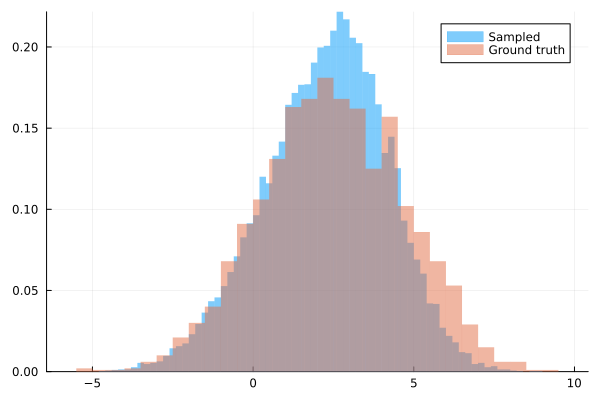

In [147]:
all_samples = vec(Array(posterior_check[:, 1:5, :]))
p = histogram(all_samples; normalize=:true, label="Sampled", opacity=0.5, linewidth=0, linecolor=:match)
p = histogram!(p, data; normalize=:true, label="Ground truth", opacity=0.5, linewidth=0, linecolor=:match)
p

Similar to how posterior predictive checks can be used to check the plausibility of the inferred posterior, a prior predictive check can be used to check the sensibility of our choice of priors. For that, we first want to sample from the prior, ignoring the data:

In [149]:
lr_chain_prior = sample(lr_model, Prior(), 1_000; progress=false)

Chains MCMC chain (1000×6×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 0.06 seconds
Compute duration  = 0.06 seconds
parameters        = slope, intercept, noise_variance
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


And then `predict` data from those prior samples, and see if it looks at all reasonable:

In [151]:
prior_check = predict(lr_model_unconditioned, lr_chain_prior)

Chains MCMC chain (1000×2000×1 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 1
Samples per chain = 1000
parameters        = data[1], data[2], data[3], data[4], data[5], data[6], data[7], data[8], data[9], data[10], data[11], data[12], data[13], data[14], data[15], data[16], data[17], data[18], data[19], data[20], data[21], data[22], data[23], data[24], data[25], data[26], data[27], data[28], data[29], data[30], data[31], data[32], data[33], data[34], data[35], data[36], data[37], data[38], data[39], data[40], data[41], data[42], data[43], data[44], data[45], data[46], data[47], data[48], data[49], data[50], data[51], data[52], data[53], data[54], data[55], data[56], data[57], data[58], data[59], data[60], data[61], data[62], data[63], data[64], data[65], data[66], data[67], data[68], data[69], data[70], data[71], data[72], data[73], data[74], data[75], data[76], data[77], data[78], data[79], data[80], data[81], data[82], data[83], data[84], data[85], data[86], d

For this, we can consider each sample in the chain to correspond to one possible linear regression model, and we can plot the data for a few of them.

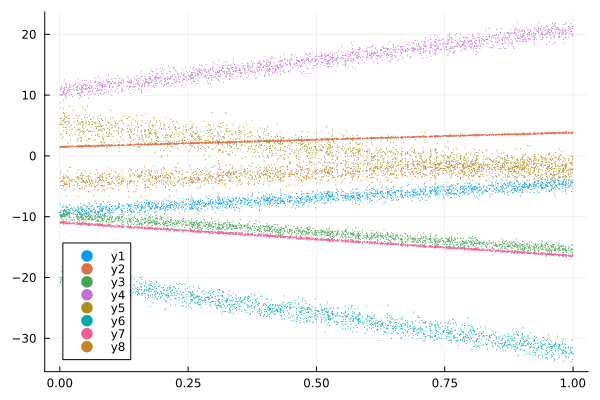

In [169]:
p = plot()
for i in 1:8
    prior_check_data = vec(Array(prior_check[i, :, :]))
    scatter!(p, predictors, prior_check_data, markersize=0.6, markerstrokewidth=0)
end
p

Looks reasonable enough. This is of course a check we should have done _before_ running inference, when we were writing the model and deciding on priors.

## Other inference methods

We've so far used the NUTS MCMC sampler, and a tiny bit of Metropolis-Hastings. Turing also has many more samplers, and inference methods other than Monte Carlo sampling.

We won't exhaustively cover the various Markov Chain Monte Carlo samplers Turing has, but to highlight a few:

- `NUTS` is a good default and a starting point. It is the most widely used sampler in the probabilistic programming world.
- `HMC`, for Hamiltonian Monte Carlo, is like `NUTS`, but with more parameters you need to choose manually. You may need to resort to it as a component sampler in Gibbs sampling (see below).
- `MH`, for Metropolis-Hastings, does both the classic random walk Metropolis-Hastings algorithms and static proposals. It's rarely more performant than NUTS or HMC, but doesn't require the model to be differentiable.
- `ESS`, for Elliptical Slice Sampling, is very efficient but only works for variables whose priors are (multivariate) normal distributions.
- `PG`, for particle Gibbs, is an interesting case: It's often slower than the other samplers, but it can also handle things the others can't. Namely, it can deal with discrete variables and variables with changing dimensionalities.

And then there's `Gibbs`. Gibbs isn't so much a sampler, but a metasampler: It allows you to take turns sampling different variables in your model with different samplers.

For instance, we could use ESS to sample the slope and the intercept for the linear regression model, while using HMC for the `noise_variance` variable (since its prior is not normal), like this:

In [189]:
sampler = Gibbs((:slope, :intercept) => ESS(), :noise_variance => MH([0.1;;]))
lr_chain_gibbs = sample(lr_model, sampler, MCMCThreads(), 1_000, 3; progress=false)

Chains MCMC chain (1000×6×3 Array{Float64, 3}):

Iterations        = 1:1:1000
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 1.45 seconds
Compute duration  = 1.39 seconds
parameters        = slope, intercept, noise_variance
internals         = lp, logprior, loglikelihood

Use `describe(chains)` for summary statistics and quantiles.


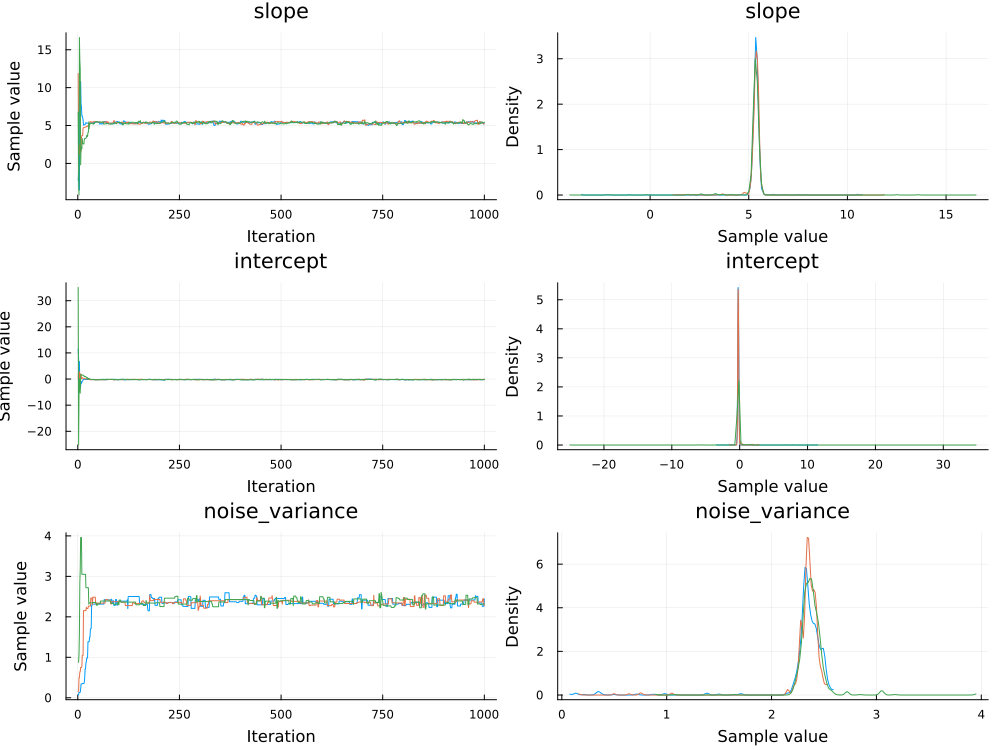

In [190]:
plot(lr_chain_gibbs)

All of these sampler algorithms also have a number of parameters you can tune, but we won't be diving into that now.

Turing's heart is in MCMC sampling, but we do support other inference methods as well, namely variational inference and mode estimation.

Variational inference tries to find the best approximation to the posterior distribution by optimising within some parametrised family of distributions, e.g. the best Gaussian to fit the posterior. It doesn't come with the same robust convergence guarantees as MCMC, but can often be faster. You can use it in Turing like so:

In [ ]:
q_init = q_meanfield_gaussian(lr_model)
lr_vi_result = vi(lr_model, q_init, 1000)